In [1]:
import sys
import os
from flim_analysis.gnn_classification.build_graphs.build_graph import *
from flim_analysis.gnn_classification.create_pytorch_geo_data.process_data_pytorch_geo import *
from flim_analysis.gnn_classification.train_model.train_gnn_model import *

from utils.data_func import *
from utils.auxiliary_func import *
from utils.plots_func import *

import config.const as const
import config.params as params

 # GNN: Patch-Wise

The GNN steps were performed using the **`flim_torch`** Python environment.

 #### Steps:
1. **Build Graphs**  
   For each patch, a spatial graph is created where:
   - Nodes represent individual nuclei with FLIM features
   - Edges connect nearby nuclei based on a distance threshold
   - Graphs are saved per patch

2. **Convert to PyTorch Geometric Format**  
   The saved graphs are converted to `torch_geometric.data.Data` objects.
   These are the required format for training GNN models with the PyTorch Geometric (PyG) framework.

3. **Train GNN Models**  
   The PyTorch Geometric dataset is used to train a GNN model (e.g., GAT or GCN) with stratified k-fold cross-validation:
   - Subgraphs are split into training, validation, and test sets by LEAP ID  
   - AUC scores are computed at both the subgraph and LEAP level  
   - Uncertain predictions (probabilities between 0.4 and 0.6) can be filtered  
   - Key result files include:
     - `seed_results.pkl`: predictions and metrics per seed  
     - `models_dict.pth`: trained models  
     - `k_fold_results.csv`: full subgraph predictions  
     - `k_fold_aggregation_results.csv`: LEAP-level performance  
     - `summary_results.pkl`: overall summary across all seeds

This pipeline enables patch-level modeling of tissue microenvironments using GNNs.

> **NOTE:** Run this only AFTER patch-wise feature extraction is complete.


## Define Parameters

In [4]:
patch_size = 1500
overlap = 0.75
max_dist = 30
feature_type = 'lifetime'
tissue_resolution = 'patch_tissue'

## Build Graph

This section builds spatial graphs for FLIM patch data.

- Loads filtered patch-level features from CSV, based on `patch_size` and `overlap`
- Groups the data by `leap_ID` and `patch_ID`
- Builds a spatial graph for each patch using Delaunay triangulation
- Connects nodes (nuclei) that are within `max_dist` pixels
- Saves each graph and a mapping dictionary to disk

These graphs capture local spatial structure of cell features, enabling graph-based analysis across patches.


In [5]:
print(f"start build graphs for patch size {patch_size}, overlap {overlap}")
df_file_path = os.path.join(const.patch_dir, f'size_{patch_size}_overlap_{overlap}', f"FLIM_features_patches_size_{patch_size}_overlap_{overlap}_after_filter.csv")
print(df_file_path)
patch_tissue_features_df = pd.read_csv(df_file_path, dtype = {'leap_ID': str})

start build graphs for patch size 1500, overlap 0.75
/sise/assafzar-group/assafzar/reut/Test_FLIM/from_FLIM_dir/patches_tissue/size_1500_overlap_0.75/FLIM_features_patches_size_1500_overlap_0.75_after_filter.csv


In [6]:
print(f"start max distance {max_dist}")
graph_file_dir = os.path.join(const.gnn_dir, feature_type, 'patch_tissue', f"max_distance_{max_dist}", 'graphs_data')
print(graph_file_dir)
graphs = create_patches_graphs_parallel(patch_tissue_features_df, ['leap_ID', 'patch_ID'], feature_type, max_dist, save_dir=graph_file_dir, local_params=f'size_{patch_size}_overlap_{overlap}')
print(f"finish max distance {max_dist}")
    
print(f"finish build graphs for patch size {patch_size}, overlap {overlap}, max distance {max_dist}")

start max distance 30
/sise/assafzar-group/assafzar/reut/Test_FLIM/from_FLIM_dir/gnn/lifetime/patch_tissue/max_distance_30/graphs_data
start with 015_1503_1127_3003_2627
start with 015_1503_2252_3003_3752
start with 015_1128_752_2628_2252
start with 015_1128_1502_2628_3002
start with 015_1128_1127_2628_2627
start with 015_1128_1877_2628_3377
start with 015_1503_752_3003_2252
start with 015_1503_2_3003_1502
start with 015_1128_377_2628_1877
start with 015_1128_2_2628_1502
start with 015_1503_377_3003_1877
start with 015_1128_2252_2628_3752
start with 015_1878_1127_3378_2627
start with 015_1503_1502_3003_3002
start with 015_1878_1502_3378_3002
finish with 015_1128_2252_2628_3752
finish with 015_1503_2252_3003_3752
finish with 015_1128_1877_2628_3377
start with 015_1878_1877_3378_3377
start with 015_1878_2252_3378_3752
finish with 015_1128_1502_2628_3002
start with 015_1878_2_3378_1502
finish with 015_1878_2252_3378_3752
start with 015_1878_377_3378_1877
finish with 015_1128_1127_2628_262

## Create PyTorch Geometric data

This section converts spatial graphs into PyTorch Geometric `Data` objects:

- Loads each graph from disk and extracts node features and connectivity
- Normalizes node features (e.g., min-max)
- Builds a dataset of `torch_geometric.data.Data` objects
- Saves:
  - `data_pytorch_geo.pkl`: PyTorch Geometric graph data
  - `graphs_df_pytorch_geo.pkl`: metadata linking graphs to LEAP samples and labels

This format is required for training GNN models using PyTorch Geometric.


In [7]:
print(f"start create pytorch geo data for feature-{feature_type}, max distance-{max_dist} patch size {patch_size}, overlap {overlap}")

create_gnn_data_patches(feature_type, max_dist, patch_size, overlap)

print(f"finish create pytorch geo data for feature-{feature_type}, max distance-{max_dist} patch size {patch_size}, overlap {overlap}")

start create pytorch geo data for feature-lifetime, max distance-30 patch size 1500, overlap 0.75
create_mapping_df
Core Responder Count: 30
Core Non-Responder Count: 23
Resection Count: 17
process the data to pytorch geo data


100%|██████████| 13893/13893 [17:50<00:00, 12.98it/s] 


add pytorch geo data index
Saved pytorch_geo_data to /sise/assafzar-group/assafzar/reut/Test_FLIM/from_FLIM_dir/gnn/lifetime/patch_tissue/max_distance_30/pytorch_geo/size_1500_overlap_0.75/data/data_pytorch_geo.pkl
Saved subgraph_df_pytorch_geo to /sise/assafzar-group/assafzar/reut/Test_FLIM/from_FLIM_dir/gnn/lifetime/patch_tissue/max_distance_30/pytorch_geo/size_1500_overlap_0.75/data/graphs_df_pytorch_geo.pkl
finish create pytorch geo data for feature-lifetime, max distance-30 patch size 1500, overlap 0.75


## Train GNN model

This section performs model training and evaluation using cross-validation:

- Loads the normalized PyTorch Geometric graph dataset
- Trains the GNN model GAT on multiple seeds and folds
- Uses stratified K-fold split to ensure balanced class distribution
- Computes:
  - AUC on subgraph predictions
  - AUC after aggregating predictions per LEAP sample
  - Filtered aggregation excluding uncertain predictions (prob ∈ [0.4, 0.6])
- Saves:
  - `seed_results.pkl` — per-seed prediction results (AUC, FPR, TPR, etc.)
  - `models_dict.pth` — best model state for each fold
  - `k_fold_results.csv` — combined subgraph-level prediction results
  - `k_fold_aggregation_results.csv` — aggregated LEAP-level performance
  - `summary_results.pkl` — summary of best/median AUCs across configurations

> **Note:**  
> The training configuration is controlled by the `config.params` dictionary:  
> - `model_custom_params` defines the GNN hyperparameters, including `epochs`.  
> - `seeds_amount` sets the number of random seeds used for repeated training.  
>   
> **For this notebook run:**  
> - `epochs = 5`  
> - `seeds_amount = 3`

This step enables robust evaluation of spatial learning on FLIM graph data.


In [5]:
model_params_dict = params.model_params[1]
model_params_dict

{'model_type': 'GAT',
 'hidden_layers': [64, 128, 64],
 'output_size': 1,
 'pooling': 'max',
 'heads': 1,
 'weight_decay': 0.0001,
 'epochs': 5,
 'class_ratio': 1.0,
 'dropout_rate': 0.1,
 'batch_size': 32,
 'test_ratio': 0.1,
 'lr': 0.0001}

In [8]:
run_patch_gnn_pipeline_per_one_model_parameters(
    feature_type=feature_type,
    patch_size=patch_size,
    overlap=overlap,
    max_dist=30,
    k_out=5,
    model_params=model_params_dict,
    seeds_amount=params.seeds_amount,
    aggregation=True,
    tissue_resolution='patch_tissue'
)

Evaluation seeds: [1825, 410, 4507]
Loading data from /sise/assafzar-group/assafzar/reut/Test_FLIM/from_FLIM_dir/gnn/lifetime/patch_tissue/max_distance_30/pytorch_geo/size_1500_overlap_0.75/data...
Start processing model parameters: model_type=GAT, hidden_layers=[64, 128, 64], output_size=1, pooling=max, heads=1, weight_decay=0.0001, epochs=5, class_ratio=1.0, dropout_rate=0.1, batch_size=32, test_ratio=0.1, lr=0.0001
  Start processing seed=1825
start with split 1
Epoch 1/5, Training Loss: 0.6698
Validation Loss: 0.6825
Epoch 2/5, Training Loss: 0.6281
Validation Loss: 0.6829
Epoch 3/5, Training Loss: 0.5988
Validation Loss: 0.6805
Epoch 4/5, Training Loss: 0.5747
Validation Loss: 0.6822
Epoch 5/5, Training Loss: 0.5726
Validation Loss: 0.6663
finish with split 1
start with split 2
Epoch 1/5, Training Loss: 0.6749
Validation Loss: 0.6576
Epoch 2/5, Training Loss: 0.6123
Validation Loss: 0.6325
Epoch 3/5, Training Loss: 0.5809
Validation Loss: 0.6082
Epoch 4/5, Training Loss: 0.5637
Va

### Visualization of GNN models results

> **Note on `date` parameter:**  
> The variable `date = '05_10_2025'` refers to the **timestamped directory** where model results are saved.  
> Make sure to **update this date** to match the folder name corresponding to your specific model training run.  

In [3]:
date = '05_10_2025' 

In [6]:
model_dir = build_gnn_model_dir_name(model_params_dict)

# Create the directory path

gnn_results_dir = os.path.join(
    const.gnn_dir,
    feature_type,
    tissue_resolution,
    f"max_distance_{max_dist}",
    "pytorch_geo",
    f"size_{patch_size}_overlap_{overlap}",
    "results",
    date)

model_result_dir = os.path.join(gnn_results_dir, model_dir)

print(model_result_dir)

/sise/assafzar-group/assafzar/reut/Test_FLIM/from_FLIM_dir/gnn/lifetime/patch_tissue/max_distance_30/pytorch_geo/size_1500_overlap_0.75/results/05_10_2025/batch_size_32_class_ratio_1p0_dropout_rate_0p1_epochs_5_heads_1_hidden_layers_[64, 128, 64]_lr_0p0001_model_type_GAT_output_size_1_pooling_max_test_ratio_0p1_weight_decay_0p0001


In [7]:
seeds_gnn_file_path = os.path.join(model_result_dir, "seed_results.pkl")
seeds_gnn_df = pd.read_pickle(seeds_gnn_file_path)
seeds_gnn_df.head()

,seed_val,auc_score,fpr,tpr,auc_agg,fpr_agg,tpr_agg,auc_agg_filter,fpr_agg_filter,tpr_agg_filter
0,1825,0.644159,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0001231830500123183, 0.000739098300073...",0.695652,"[0.0, 0.0, 0.0, 0.043478260869565216, 0.043478...","[0.0, 0.03333333333333333, 0.1, 0.1, 0.1666666...",0.649275,"[0.0, 0.0, 0.0, 0.043478260869565216, 0.043478...","[0.0, 0.03333333333333333, 0.1, 0.1, 0.1333333..."
1,410,0.597040,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.000692640692640692...","[0.0, 0.0001231830500123183, 0.000246366100024...",0.633333,"[0.0, 0.043478260869565216, 0.0434782608695652...","[0.0, 0.0, 0.13333333333333333, 0.133333333333...",0.562319,"[0.0, 0.0, 0.0, 0.08695652173913043, 0.0869565...","[0.0, 0.03333333333333333, 0.06666666666666667..."
2,4507,0.717338,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0002463661000246366, 0.000369549150036...",0.753623,"[0.0, 0.0, 0.043478260869565216, 0.04347826086...","[0.0, 0.03333333333333333, 0.03333333333333333...",0.633333,"[0.0, 0.0, 0.043478260869565216, 0.04347826086...","[0.0, 0.03333333333333333, 0.03333333333333333..."


Median AUC: 0.6956521739130435


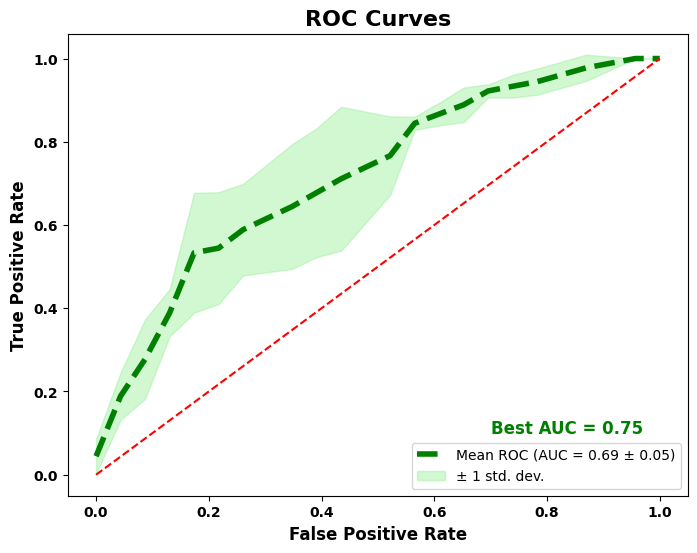

In [9]:
seed_list_gnn, auc_list_gnn, fpr_list_gnn, tpr_list_gnn = extract_gnn_seed_results(model_result_dir,  'auc_agg', 'tpr_agg', 'fpr_agg')
plot_mean_auc_roc_lists(fpr_list_gnn, tpr_list_gnn, auc_list_gnn)